# Tuesday Health: Hospice Quality Metrics Technical Assessment
Author: Kyle Biron  

### Imports

In [2]:
import duckdb
import numpy
import pandas as pd
from pprint import pprint
import seaborn as sns
import matplotlib.pyplot as plt

# configure pandas to show full string values and all rows/columns
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

### Connect to db

In [3]:
# set duckdb directory path
db_dir = "/Users/kyle/Documents/personal_projects/repos/kyle-tuesday-health-tech-assignment/hospice_quality_metrics/db"

# connect to an existing duckdb database
con = duckdb.connect(f'{db_dir}/hospice_quality_metrics.db')

# list and print all tables in the connected duckdb database
tables = con.execute("SHOW TABLES").df()
print(tables)

                              name
0  fact_hospice_provider_flattened
1             stg_hospice_provider


In [8]:
# Query the database
stg_hospice_provider_df = con.execute("SELECT * FROM stg_hospice_provider limit 5").df()

# Display the dataframe
display(stg_hospice_provider_df)

,ccn,facility_name,address_line_1,address_line_2,city_town,State,zip_code,county_parish,telephone_number,cms_region,measure_code,measure_name,Score,Footnote,measure_date_range,measure_from_date,measure_end_date
0,001500,AGAVE HOSPICE,3240 EAST UNION HILLS DRIVE SUITE 145 ROOM A,None,PHOENIX,AZ,85050,Maricopa,(602) 855-3500,9,H_001_01_DENOMINATOR,None,136,None,10/01/2022-09/30/2023,10/01/2022,09/30/2023
1,001500,AGAVE HOSPICE,3240 EAST UNION HILLS DRIVE SUITE 145 ROOM A,None,PHOENIX,AZ,85050,Maricopa,(602) 855-3500,9,H_001_01_OBSERVED,Hospice and Palliative Care Treatment Preferences,100.0,None,10/01/2022-09/30/2023,10/01/2022,09/30/2023
2,001500,AGAVE HOSPICE,3240 EAST UNION HILLS DRIVE SUITE 145 ROOM A,None,PHOENIX,AZ,85050,Maricopa,(602) 855-3500,9,H_002_01_DENOMINATOR,None,136,None,10/01/2022-09/30/2023,10/01/2022,09/30/2023
3,001500,AGAVE HOSPICE,3240 EAST UNION HILLS DRIVE SUITE 145 ROOM A,None,PHOENIX,AZ,85050,Maricopa,(602) 855-3500,9,H_002_01_OBSERVED,Beliefs & Values Addressed (if desired by the patient),100.0,None,10/01/2022-09/30/2023,10/01/2022,09/30/2023
4,001500,AGAVE HOSPICE,3240 EAST UNION HILLS DRIVE SUITE 145 ROOM A,None,PHOENIX,AZ,85050,Maricopa,(602) 855-3500,9,H_003_01_DENOMINATOR,None,136,None,10/01/2022-09/30/2023,10/01/2022,09/30/2023


### 1. Correlation Analysis: HIS Composite Process Metric & HCI Decile

#### load fact_hospice_provider_flattened to a df

In [4]:
fact_hospice_provider_flattened_df = con.execute("SELECT * FROM fact_hospice_provider_flattened").df()
print(fact_hospice_provider_flattened_df.columns)

Index(['ccn', 'cms_region', 'h_008_01_observed_score', 'h_012_00_observed_score', 'h_008_01_observed_footnote', 'h_012_00_observed_footnote'], dtype='object')


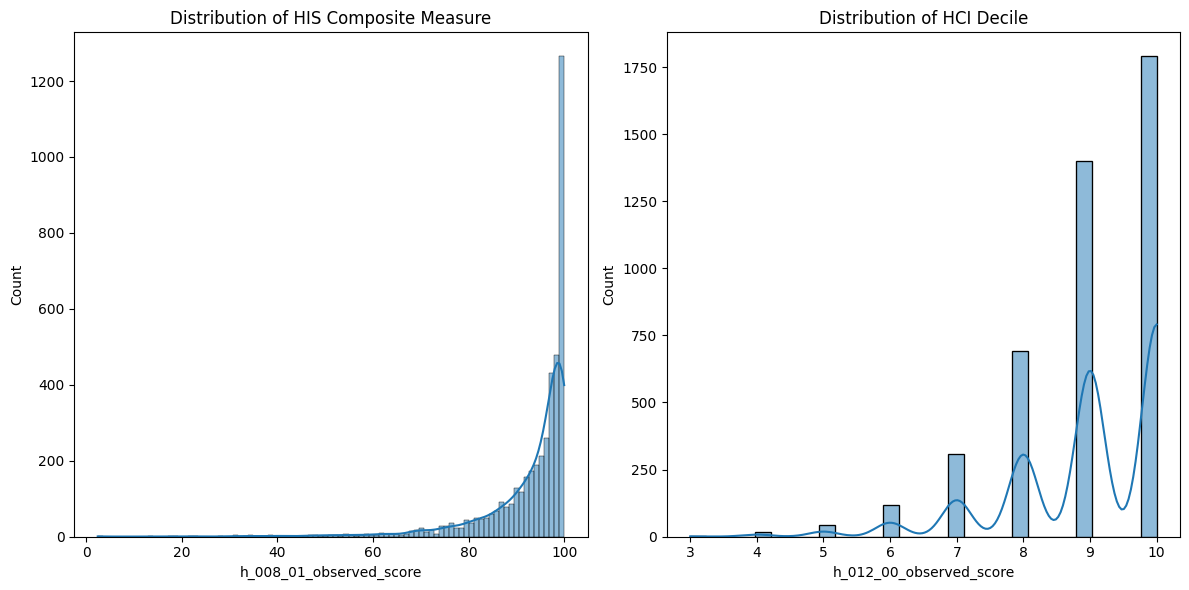

In [20]:
# configure subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# HIS Composite Measure plot
sns.histplot(data=fact_hospice_provider_flattened_df, x="h_008_01_observed_score", kde=True, ax=axes[0])
axes[0].set_title('Distribution of HIS Composite Measure')

# HCI Decile plot
sns.histplot(data=fact_hospice_provider_flattened_df, x="h_012_00_observed_score", kde=True, ax=axes[1])
axes[1].set_title('Distribution of HCI Decile')

# show plots
plt.tight_layout()
plt.show()

In [16]:
# Pearson correlation
correlation_pearson = fact_hospice_provider_flattened_df[['h_008_01_observed_score', 'h_012_00_observed_score']].corr()

print("Correlation Matrix: Pearson")
print(correlation_pearson)

Correlation Matrix: Pearson
                         h_008_01_observed_score  h_012_00_observed_score
h_008_01_observed_score                 1.000000                 0.223246
h_012_00_observed_score                 0.223246                 1.000000


In [18]:
# Spearman correlation
correlation_spearman = fact_hospice_provider_flattened_df[['h_008_01_observed_score', 'h_012_00_observed_score']].corr(method='spearman')

print("Correlation Matrix: Spearman:")
print(correlation_spearman)

Correlation Matrix: Spearman:
                         h_008_01_observed_score  h_012_00_observed_score
h_008_01_observed_score                 1.000000                 0.227345
h_012_00_observed_score                 0.227345                 1.000000


In [21]:
correlation_spearman_by_region = fact_hospice_provider_flattened_df.groupby('cms_region')[
    ['h_008_01_observed_score', 'h_012_00_observed_score']
].corr(method='spearman')

print(correlation_spearman_by_region)

                                    h_008_01_observed_score  h_012_00_observed_score
cms_region                                                                          
1          h_008_01_observed_score                 1.000000                 0.174107
           h_012_00_observed_score                 0.174107                 1.000000
2          h_008_01_observed_score                 1.000000                 0.205653
           h_012_00_observed_score                 0.205653                 1.000000
3          h_008_01_observed_score                 1.000000                 0.253217
           h_012_00_observed_score                 0.253217                 1.000000
4          h_008_01_observed_score                 1.000000                 0.044258
           h_012_00_observed_score                 0.044258                 1.000000
5          h_008_01_observed_score                 1.000000                 0.155562
           h_012_00_observed_score                 0.155562      

In [53]:
con.close()